In [1]:
!nvidia-smi

Wed May 14 19:26:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060 6GB  WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P8              7W /  120W |     435MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [3]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import os
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


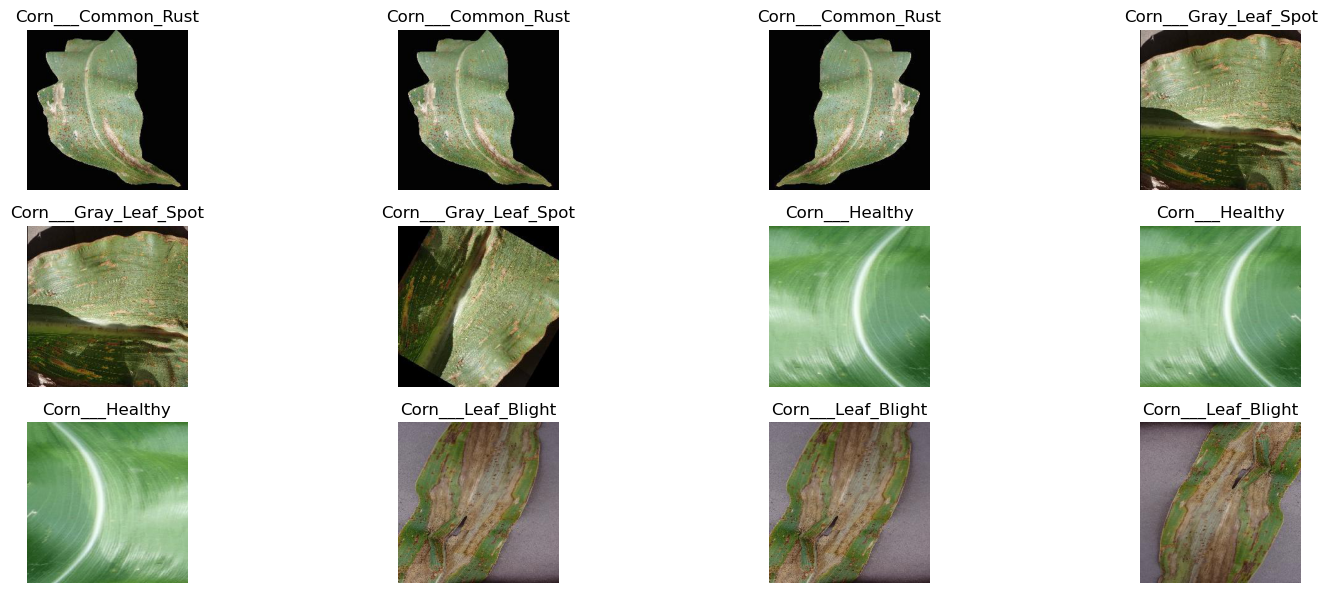

In [6]:
# Set the root path to your dataset
dataset_path = 'D:\DOCS\PYTHON\CropDisease\Crop___DIsease'  # ← change this to your actual path

# Get all class folders
class_folders = sorted(os.listdir(dataset_path))

# How many images to show
num_images_to_show = 12
images_per_row = 4

# Collect image paths and their labels
image_paths = []
labels = []

for class_name in class_folders:
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir)[:3]:  # take first 3 images per class
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_paths.append(os.path.join(class_dir, img_name))
                labels.append(class_name)

# Plot using subplots
plt.figure(figsize=(15, 8))

for i in range(min(num_images_to_show, len(image_paths))):
    img = Image.open(image_paths[i])  # Open image using PIL
    img = img.convert('RGB')  # Ensure image is in RGB mode for displaying

    plt.subplot(num_images_to_show // images_per_row + 1, images_per_row, i + 1)
    plt.imshow(img)
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
crop_class_map = sorted(os.listdir(r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease'))
num_class = len(crop_class_map)
print(num_class)

15


In [8]:
class CropDataset(Dataset):
    def __init__(self, root_dir, augment=False):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(root_dir))
        self.augment = augment

        valid_extensions = ('.bmp', '.png', '.jpg', '.jpeg')

        for label, class_name in enumerate(self.class_names):
            class_path = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_path):
                if image_name.lower().endswith(valid_extensions):
                    image_path = os.path.join(class_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(label)

        # Data augmentation transformations
        self.augmentation_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))
        ])

        # Standard preprocessing transformations
        self.preprocess_transforms = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize for VGG/ResNet input
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path).convert("RGB")
            
            # Apply augmentation if enabled
            if self.augment:
                image = self.augmentation_transforms(image)
                
            # Apply standard preprocessing
            image = self.preprocess_transforms(image)
            
        except Exception as e:
            raise ValueError(f"Failed to load image: {image_path} — {e}")

        return image, torch.tensor(label, dtype=torch.long)

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, DataLoader
import numpy as np
import random
import torch
import pickle

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Generator for reproducibility
g = torch.Generator()
g.manual_seed(42)

# ✅ Load full dataset without augmentation
full_dataset = CropDataset(root_dir=r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease', augment=False)
labels = full_dataset.labels

# ✅ Stratified split: Train / Val / Test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
total_size = len(labels)

# First split: Train vs Temp (val+test)
sss = StratifiedShuffleSplit(n_splits=1, test_size=(1 - train_ratio), random_state=42)
train_idx, temp_idx = next(sss.split(np.zeros(total_size), labels))

# Second split: Val vs Test
temp_labels = np.array(labels)[temp_idx]
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss_val_test.split(np.zeros(len(temp_idx)), temp_labels))

# Map back to original indices
val_idx = np.array(temp_idx)[val_idx]
test_idx = np.array(temp_idx)[test_idx]

# ✅ Create dataset splits
train_dataset = CropDataset(root_dir=r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease', augment=True)
train_dataset = Subset(train_dataset, train_idx)

val_dataset = CropDataset(root_dir=r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease', augment=False)
val_dataset = Subset(val_dataset, val_idx)

test_dataset = CropDataset(root_dir=r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease', augment=False)
test_dataset = Subset(test_dataset, test_idx)

# ✅ Create DataLoaders (optimized)
batch_size = 16
num_workers = 0  # Adjust based on your CPU cores

full_train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True, worker_init_fn=seed_worker, generator=g
)

full_val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, worker_init_fn=seed_worker, generator=g
)

full_test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, worker_init_fn=seed_worker, generator=g
)

# ✅ Optional sanity check
print(f"Total: {total_size}, Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# ================== Save Test Split ==================

# Path to save the test split indices
test_split_path = 'test_split_indices.pkl'

# Save the test indices
with open(test_split_path, 'wb') as f:
    pickle.dump(list(test_idx), f)

print(f"Test split indices saved to {test_split_path}")

Total: 31053, Train: 21737, Val: 4658, Test: 4658
Test split indices saved to test_split_indices.pkl


In [10]:
# ================== Dataset Split Consistency Check ==================

# Function to split dataset and track splits
def get_splits(dataset):
    labels = dataset.labels
    total_size = len(labels)

    # First split: Train vs Temp (val+test)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=(1 - train_ratio), random_state=42)
    train_idx, temp_idx = next(sss.split(np.zeros(total_size), labels))

    # Second split: Val vs Test
    temp_labels = np.array(labels)[temp_idx]
    sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_idx, test_idx = next(sss_val_test.split(np.zeros(len(temp_idx)), temp_labels))

    # Map back to original indices
    val_idx = np.array(temp_idx)[val_idx]
    test_idx = np.array(temp_idx)[test_idx]

    train_images = sorted([dataset.image_paths[i] for i in train_idx])
    val_images = sorted([dataset.image_paths[i] for i in val_idx])
    test_images = sorted([dataset.image_paths[i] for i in test_idx])

    return train_images, val_images, test_images

# Reference split to compare against
ref_train, ref_val, ref_test = get_splits(full_dataset)

# Number of iterations to run
num_iterations = 1000

# Checking consistency across multiple runs
for iteration in range(num_iterations):
    current_train, current_val, current_test = get_splits(full_dataset)

    if current_train != ref_train or current_val != ref_val or current_test != ref_test:
        print(f"Inconsistency found in iteration {iteration}")
        break
else:
    print("All splits are consistent across 1000 iterations")

All splits are consistent across 1000 iterations


In [13]:
lr = 1e-4
dropout_rate = 0.3
optimizer_name = "Adam"
hidden_units = 512
epochs = 30

In [15]:
import torch.nn as nn
import torchvision.models as models

class EfficientNetFineTune(nn.Module):
    def __init__(self, num_class, hidden_units, dropout_rate):
        super().__init__()

        # Load the pre-trained EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        # Get the input features of the fully connected layer
        in_features = self.efficientnet.classifier[1].in_features

        # Modify the fully connected layer with custom hidden units and dropout rate
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(in_features, hidden_units),  # Custom hidden layer
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),  # Activation function
            nn.Dropout(dropout_rate),  # Dropout for regularization

            nn.Linear(hidden_units, num_class)
        )

    def forward(self, x):
        return self.efficientnet(x)

In [16]:
from torchsummary import summary

model = EfficientNetFineTune(num_class, hidden_units, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))

if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

C:\Users\Mushfiq\anaconda3\envs\PT\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mushfiq\anaconda3\envs\PT\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

C:\Users\Mushfiq\anaconda3\envs\PT\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
!nvidia-smi

Wed May 14 19:27:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060 6GB  WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   37C    P2             25W /  120W |     727MiB /   6144MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
# import os

# # Paths to your checkpoint and best model
# checkpoint_path = "checkpoint.pth"
# best_model_path = "best_model.pth"

# # Check if the checkpoint file exists and remove it
# if os.path.exists(checkpoint_path):
#     print(f"Deleting old checkpoint: {checkpoint_path}")
#     os.remove(checkpoint_path)

# # Check if the best model file exists and remove it
# if os.path.exists(best_model_path):
#     print(f"Deleting old best model: {best_model_path}")
#     os.remove(best_model_path)

# # Optionally, if you want to clear any other unnecessary files, add them here
# # Example: os.remove("another_checkpoint.pth")

# print("Old checkpoints deleted. Ready to start fresh training.")

In [19]:
import time
from tqdm import tqdm
import torch
import os
import matplotlib.pyplot as plt

# Training the model with Checkpointing and Early Stopping
train_losses = []
val_losses = []
best_val_loss = float('inf')

# File paths
checkpoint_path = "checkpoint.pth"  # Unchanged, temporary
best_model_path = "crop_best_model_efficientNet.pth"  # Updated
final_model_path = "crop_final_model_efficientNet.pth"  # Updated
final_weights_path = "crop_final_weights_efficientNet.pth"  # Updated

# Early stopping parameters
patience = 5
early_stop_counter = 0
start_epoch = 0

# Check if a checkpoint exists
if os.path.exists(checkpoint_path):
    print("Resuming training from the last checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    early_stop_counter = checkpoint['early_stop_counter']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    print(f"Resumed from epoch {start_epoch}")
else:
    print("No checkpoint found. Starting training from scratch...")

for epoch in range(start_epoch, epochs):
    start_time = time.time()
    print(f"Epoch {epoch+1}/{epochs} started")
    
    # Training Phase
    model.train()
    total_train_loss = 0

    for batch_features, batch_labels in tqdm(full_train_loader, desc='Training', leave=False):
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(full_train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}")

    # Validation Phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_features, val_labels in tqdm(full_val_loader, desc='Validating', leave=False):
            val_features, val_labels = val_features.to(device), val_labels.to(device)
            val_outputs = model(val_features)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(full_val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")

    # Check for improvement and save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save as "crop_best_model.pth"
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss,
        'early_stop_counter': early_stop_counter,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

    # Check early stopping
    if early_stop_counter >= patience:
        print("Early stopping triggered. Loading best model...")
        model.load_state_dict(torch.load(best_model_path))
        break

    # GPU Memory Monitoring
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

    print(f"Epoch duration: {time.time() - start_time:.2f} seconds")

# Save the final model and weights
torch.save(model.state_dict(), final_weights_path)  # "crop_final_weights.pth"
torch.save(model, final_model_path)  # "crop_final_model.pth"

print("Training complete. Models saved as:")
print(f"- Best model: {best_model_path}")
print(f"- Final model: {final_model_path}")
print(f"- Final weights only: {final_weights_path}")

Resuming training from the last checkpoint...


C:\Users\Mushfiq\AppData\Local\Temp\ipykernel_16720\3934199734.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resumed from epoch 4
Epoch 5/30 started


Epoch [5/30], Train Loss: 0.0644


Epoch [5/30], Validation Loss: 0.0772
Early stopping counter: 2/5
Checkpoint saved at epoch 5
GPU Memory Allocated: 95.61 MB
Epoch duration: 2201.89 seconds
Epoch 6/30 started


Epoch [6/30], Train Loss: 0.0506


Epoch [6/30], Validation Loss: 0.0509
Best model saved with validation loss: 0.0509
Checkpoint saved at epoch 6
GPU Memory Allocated: 95.61 MB
Epoch duration: 1922.69 seconds
Epoch 7/30 started


Epoch [7/30], Train Loss: 0.0497


Epoch [7/30], Validation Loss: 0.0680
Early stopping counter: 1/5
Checkpoint saved at epoch 7
GPU Memory Allocated: 95.61 MB
Epoch duration: 1917.58 seconds
Epoch 8/30 started


Epoch [8/30], Train Loss: 0.0484


Epoch [8/30], Validation Loss: 0.0615
Early stopping counter: 2/5
Checkpoint saved at epoch 8
GPU Memory Allocated: 95.61 MB
Epoch duration: 1923.44 seconds
Epoch 9/30 started


Epoch [9/30], Train Loss: 0.0758


Epoch [9/30], Validation Loss: 0.0691
Early stopping counter: 3/5
Checkpoint saved at epoch 9
GPU Memory Allocated: 95.61 MB
Epoch duration: 1962.51 seconds
Epoch 10/30 started


Epoch [10/30], Train Loss: 0.0635


Epoch [10/30], Validation Loss: 0.0526
Early stopping counter: 4/5
Checkpoint saved at epoch 10
GPU Memory Allocated: 95.61 MB
Epoch duration: 1914.03 seconds
Epoch 11/30 started


Epoch [11/30], Train Loss: 0.0499


Epoch [11/30], Validation Loss: 0.0444
Best model saved with validation loss: 0.0444
Checkpoint saved at epoch 11
GPU Memory Allocated: 95.61 MB
Epoch duration: 1917.41 seconds
Epoch 12/30 started


Epoch [12/30], Train Loss: 0.0449


Epoch [12/30], Validation Loss: 0.0428
Best model saved with validation loss: 0.0428
Checkpoint saved at epoch 12
GPU Memory Allocated: 95.61 MB
Epoch duration: 1926.96 seconds
Epoch 13/30 started


Epoch [13/30], Train Loss: 0.0419


Epoch [13/30], Validation Loss: 0.0501
Early stopping counter: 1/5
Checkpoint saved at epoch 13
GPU Memory Allocated: 95.61 MB
Epoch duration: 2040.22 seconds
Epoch 14/30 started


Epoch [14/30], Train Loss: 0.0415


Epoch [14/30], Validation Loss: 0.0540
Early stopping counter: 2/5
Checkpoint saved at epoch 14
GPU Memory Allocated: 95.61 MB
Epoch duration: 2040.47 seconds
Epoch 15/30 started


Epoch [15/30], Train Loss: 0.0408


Epoch [15/30], Validation Loss: 0.0489
Early stopping counter: 3/5
Checkpoint saved at epoch 15
GPU Memory Allocated: 95.61 MB
Epoch duration: 2092.94 seconds
Epoch 16/30 started


Epoch [16/30], Train Loss: 0.0410


Epoch [16/30], Validation Loss: 0.0430
Early stopping counter: 4/5
Checkpoint saved at epoch 16
GPU Memory Allocated: 95.61 MB
Epoch duration: 2024.95 seconds
Epoch 17/30 started


Epoch [17/30], Train Loss: 0.0333


C:\Users\Mushfiq\AppData\Local\Temp\ipykernel_16720\3934199734.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Epoch [17/30], Validation Loss: 0.0450
Early stopping counter: 5/5
Checkpoint saved at epoch 17
Early stopping triggered. Loading best model...
Training complete. Models saved as:
- Best model: crop_best_model_efficientNet.pth
- Final model: crop_final_model_efficientNet.pth
- Final weights only: crop_final_weights_efficientNet.pth


In [20]:
# evaluate best model
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the best model before evaluating
model.load_state_dict(torch.load("crop_best_model_efficientNet.pth"))  # Load the best model saved during training

# Evaluate the model after training
model.eval()
total_test_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []

# Disable gradient calculation during evaluation
with torch.no_grad():
    for images, labels in full_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the average test loss
avg_test_loss = total_test_loss / len(full_test_loader)
test_accuracy = 100 * correct / total

# Compute additional metrics (Precision, Recall, F1-Score)
precision = precision_score(all_labels, all_preds, average='macro')  # or 'weighted'
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# Print results after evaluation
print(f"Final Evaluation Results | "
      f"Test Loss: {avg_test_loss:.4f} | "
      f"Accuracy: {test_accuracy:.2f}% | "
      f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

C:\Users\Mushfiq\AppData\Local\Temp\ipykernel_16720\2164276940.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crop_best_model_efficien

Final Evaluation Results | Test Loss: 0.0502 | Accuracy: 98.33% | Precision: 0.9497 | Recall: 0.9508 | F1 Score: 0.9499


In [21]:
# Evaluate final model
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the final model object
final_model = torch.load("crop_final_model_efficientNet.pth")
final_model = final_model.to(device)
final_model.eval()

total_test_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []

# Disable gradient calculation during evaluation
with torch.no_grad():
    for images, labels in full_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the average test loss
avg_test_loss = total_test_loss / len(full_test_loader)
test_accuracy = 100 * correct / total

# Compute additional metrics (Precision, Recall, F1-Score)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# Print results after evaluation
print(f"Final Model Evaluation Results | "
      f"Test Loss: {avg_test_loss:.4f} | "
      f"Accuracy: {test_accuracy:.2f}% | "
      f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

C:\Users\Mushfiq\AppData\Local\Temp\ipykernel_16720\1341853195.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model = torch.load("crop_final_model_efficientNet.pt

Final Model Evaluation Results | Test Loss: 0.0502 | Accuracy: 98.33% | Precision: 0.9497 | Recall: 0.9508 | F1 Score: 0.9499


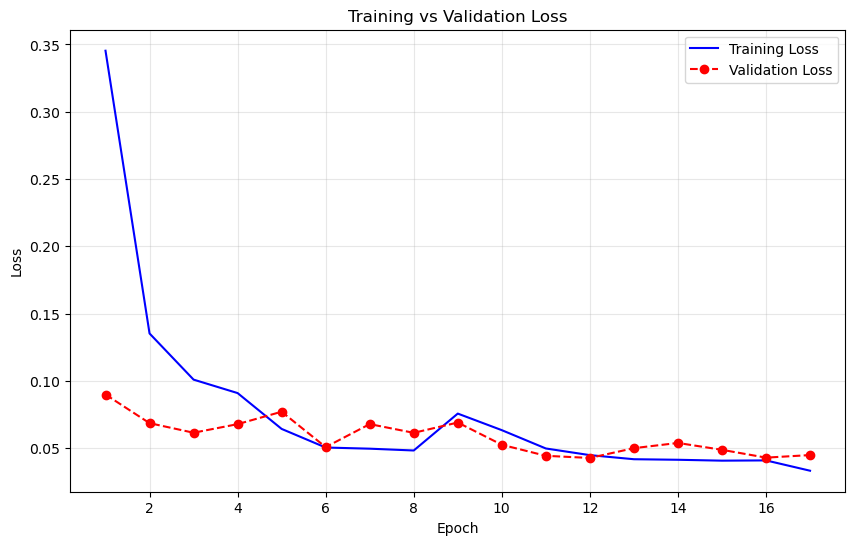

In [22]:
# Calculate the actual number of epochs completed
completed_epochs = len(train_losses)

# Generate the epochs for which validation losses are available
# As validation is now calculated every epoch, we do not need to filter the epochs
val_epochs = list(range(1, completed_epochs + 1))

# Filter the validation losses to match the actual epochs
# Here, no need for further filtering as validation loss occurs every epoch
filtered_val_losses = val_losses

plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(range(1, completed_epochs + 1), train_losses, label='Training Loss', color='b')

# Plot validation loss
plt.plot(val_epochs, filtered_val_losses, label='Validation Loss', color='r', marker='o', linestyle='--')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Show grid
plt.grid(alpha=0.3)

# Display the plot
plt.show()

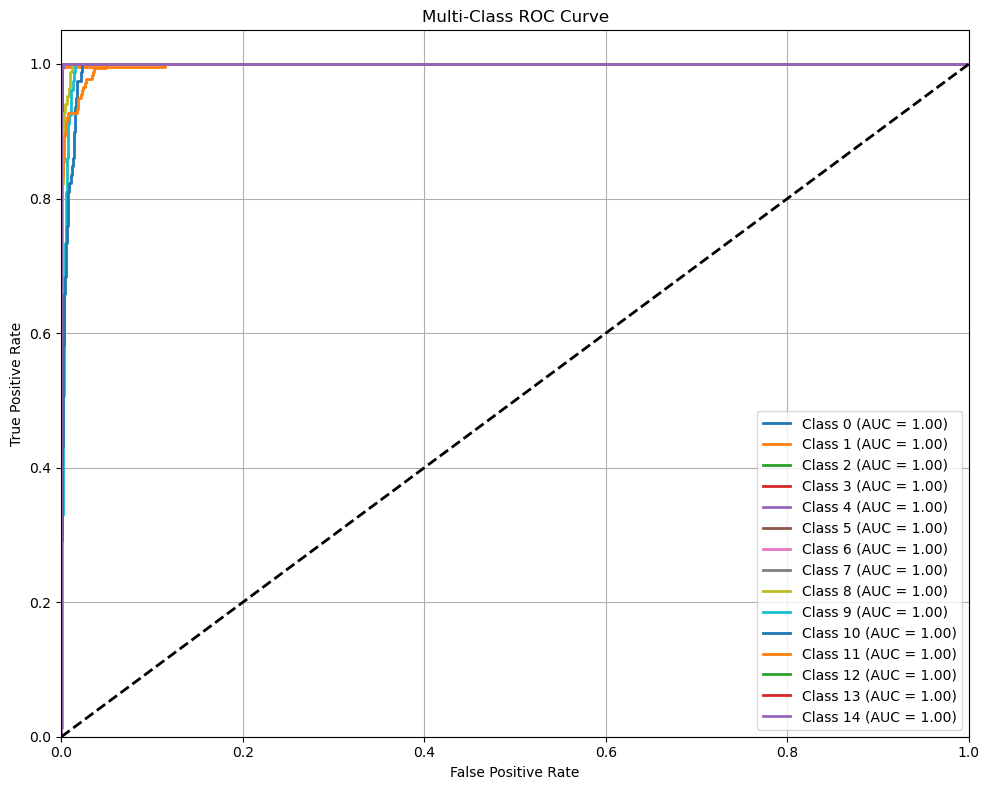

In [23]:
# ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming num_class is defined (number of classes)
# And all_labels, all_preds already collected

# 1. Get probabilities
all_probs = []

model.eval()
with torch.no_grad():
    for images, labels in full_test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

# 2. Binarize labels for multi-class ROC
all_labels_bin = label_binarize(all_labels, classes=list(range(num_class)))
all_probs = np.array(all_probs)

# 3. Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_class):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot
plt.figure(figsize=(10, 8))
for i in range(num_class):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# Assuming you already created the test_dataset using random_split

# Access the dataset inside the Subset object
test_image_paths = [test_dataset.dataset.image_paths[i] for i in test_dataset.indices[:30]]

# Print image paths
for idx, path in enumerate(test_image_paths):
    print(f"Image {idx+1}: {path}")

Image 1: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Potato___Early_Blight\655010d0-0bf7-4cba-8ebe-591a8bc5f552___RS_Early.B 7668_flipTB.JPG
Image 2: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Leaf_Blight\7348d45f-96ba-454e-b0eb-084d0284f718___RS_NLB 4242(1).JPG
Image 3: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Potato___Late_Blight\98a806fd-2839-4069-b40b-08522c34ccdc___RS_LB 3032.JPG
Image 4: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Rice___Leaf_Blast\IMG_4853.jpg
Image 5: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Leaf_Blight\ec769dd1-532c-4f81-b677-6b7b4d0d7606___RS_NLB 4140_180deg(1).JPG
Image 6: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Healthy\b7214149-73ad-481e-9227-c9fe77f10477___R.S_HL 7896 copy 2.jpg
Image 7: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Gray_Leaf_Spot\2ccec9ab-60e1-4b79-bfdc-b33d387db907___RS_GLSp 4576_90deg.JPG
Image 8: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Invalid\flower_0048.jpg
Image 9: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\R

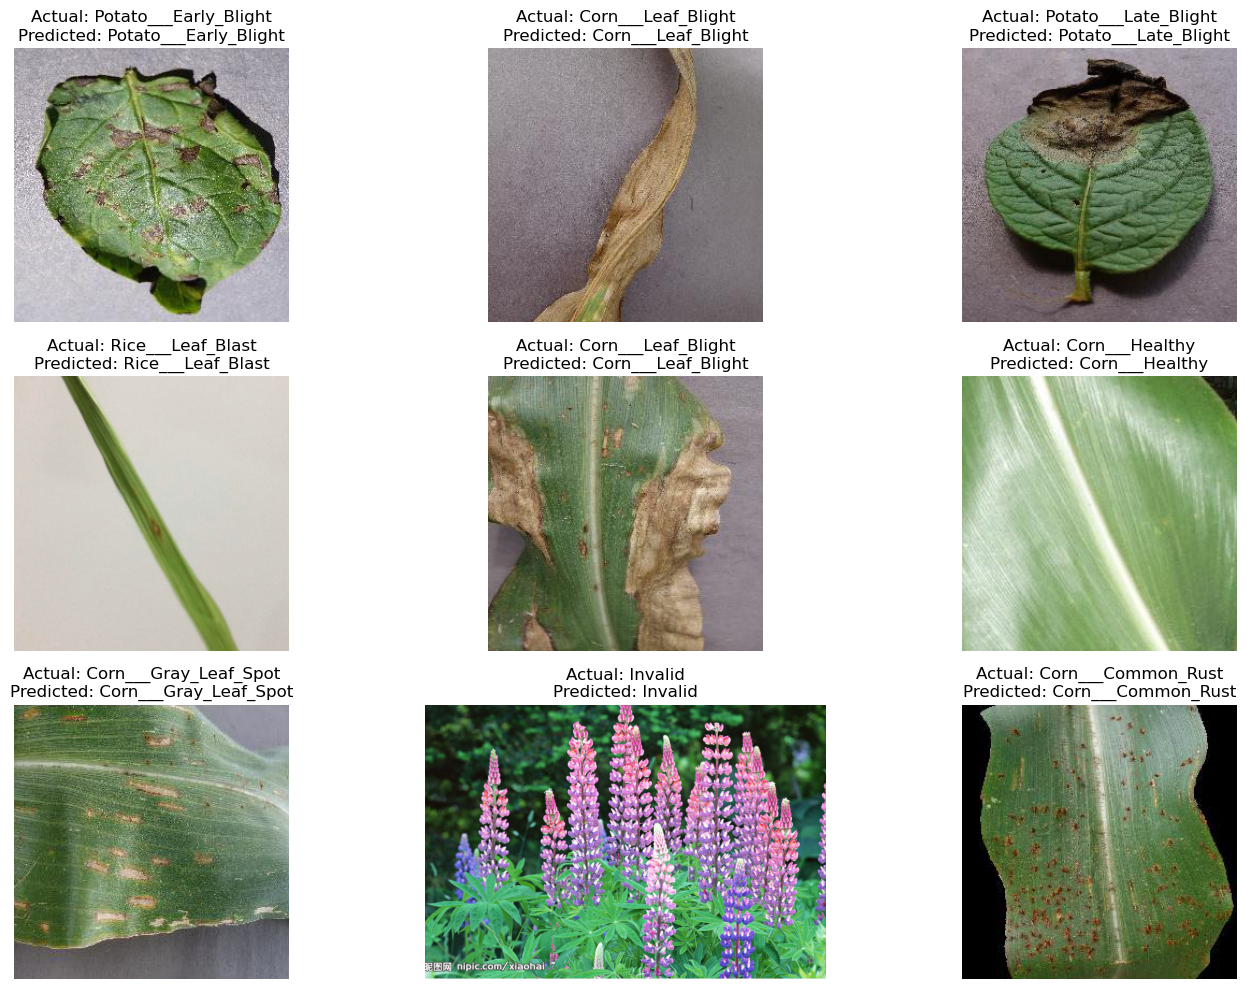

In [34]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from PIL import Image
import os

# ---------------------------
# Configuration
# ---------------------------

# Sample multiple image paths (adjust the paths as needed)
image_paths = [
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Potato___Early_Blight\\655010d0-0bf7-4cba-8ebe-591a8bc5f552___RS_Early.B 7668_flipTB.JPG',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Corn___Leaf_Blight\\7348d45f-96ba-454e-b0eb-084d0284f718___RS_NLB 4242(1).JPG',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Potato___Late_Blight\\98a806fd-2839-4069-b40b-08522c34ccdc___RS_LB 3032.JPG',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Rice___Leaf_Blast\\IMG_4853.jpg',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Corn___Leaf_Blight\\ec769dd1-532c-4f81-b677-6b7b4d0d7606___RS_NLB 4140_180deg(1).JPG',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Corn___Healthy\\b7214149-73ad-481e-9227-c9fe77f10477___R.S_HL 7896 copy 2.jpg',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Corn___Gray_Leaf_Spot\\2ccec9ab-60e1-4b79-bfdc-b33d387db907___RS_GLSp 4576_90deg.JPG',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Invalid\\flower_0048.jpg',
    'D:\\DOCS\\PYTHON\\CropDisease\\Crop___DIsease\\Corn___Common_Rust\\RS_Rust 2545_flipLR(1).JPG'
]


# Load your model here
# model = YourModelClass(...)
# model.load_state_dict(torch.load("your_model_path.pth"))
model.to(device)
model.eval()


# ---------------------------
# Helper functions
# ---------------------------

def load_and_preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize for VGG/ResNet input
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

def get_actual_class(image_path):
    return os.path.basename(os.path.dirname(image_path))

# ---------------------------
# Prediction and Display
# ---------------------------

# Set up the subplot grid
n_images = len(image_paths)
cols = 3
rows = (n_images + cols - 1) // cols  # Calculate number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for idx, image_path in enumerate(image_paths):
    actual_class = get_actual_class(image_path)
    image_tensor = load_and_preprocess_image(image_path).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_class = crop_class_map[predicted_idx.item()]
    
    # Reopen image for display (no transformation)
    img_display = Image.open(image_path)
    
    # Display image and prediction
    axes[idx].imshow(img_display)
    axes[idx].set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    axes[idx].axis('off')

# Hide any remaining axes if the number of images is less than the grid size
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()